# Deepweeds - MobileNetv3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

tf.__version__

2025-06-28 07:40:21.083669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-28 07:40:21.083819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-28 07:40:21.227061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

# Configurations

In [2]:
INFERENCE_DEVICE = 'GPU:0' if len(tf.config.list_physical_devices('GPU')) else 'CPU:0'

################################
###### Configurations #########
##############################
seed = 999
SEED = seed
USE_DETERMINISTIC = True
K_FOLD_INDEX = 1
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME=f"MobileNetV3Small_KF{K_FOLD_INDEX+1}.keras"
IMG_SIZE=(224,224,3)

## Training Configurations
TRAIN_BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 16 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-7 ## Minimum Learning Rate for ReduceLROnPlateau Callback
##
USE_WARMUP = False
WARMUP_EPOCHS = 5
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCHS
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.3

##### Base Model Freezing Part
INIT_LR2 = 2e-6 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-4 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau

#### -- Optimizer
USE_ADAMW = '2.15' in tf.__version__
#########################################
isKaggle = 'kaggle' in os.getcwd()

if isKaggle:
    DATASET_PATH = "/kaggle/input/deepweeds"
    IMAGE_DATASET_PATH = "/kaggle/input/deepweeds/images" ## For Kaggle
    DATASET_OUTPUT_PATH = "/kaggle/working/deepweeds_9c" ## For Kaggle
else:
    try:
        DATASET_PATH = reganmaharjan_deepweeds_path
        DATASET_OUTPUT_PATH = '/content/dataset_9c' ## For GoogleColab
        IMAGE_DATASET_PATH = reganmaharjan_deepweeds_path + '/images' ## For GoogleColab
    except:
        DATASET_PATH = ''
        IMAGE_DATASET_PATH = '' ## Assign The Image Path
        DATASET_OUTPUT_PATH = '' ## Assign The path where the Images are to ogranized for Data Generator from Directory


isTPU = False
fixDatasetBatch = False ## if True: duplicates files randomly such that each batch contains same no.of files - Required when isTPU=True.

In [3]:
print("Tensorflow version " + tf.__version__)
if tf.config.list_logical_devices('TPU'):
    if isKaggle:
        # On TPU VMs use this line instead:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  ## if kaggle
    else:        
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver() ## if colab

    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    #---------
    strategy = tf.distribute.TPUStrategy(resolver)
    print('TPU available')
    isTPU = True
else: ### If GPU or CPU
    if tf.config.list_logical_devices('GPU'): 
        print('GPU available')
    else:
        print("Only CPU available")
       
    # For testing without a TPU use this line instead: 
    # strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    strategy = tf.distribute.MirroredStrategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)
if isTPU:
    USE_ADAMW = False
    LR_REDUCTION_PATIENCE = 5
    ES_PATIENCE = 27
    print("Use ADAM with TPU")

Tensorflow version 2.15.0
GPU available
REPLICAS:  1


In [4]:
def seedEverything(seed=42, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    tf.keras.utils.set_random_seed(seed)
    
    if deterministic:
        tf.config.experimental.enable_op_determinism()
        
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED, USE_DETERMINISTIC)
tf.config.set_soft_device_placement(True)

In [5]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [6]:
try:
    data_info = pd.read_csv(f"{DATASET_PATH}/labels.csv") ## For Kaggle
except:
    data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [7]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [8]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [9]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 2 out of 5 folds
-------------------------------------------------



In [11]:
## Using Folds Used in The DeepWeeds Paper
try:
    train_data = pd.read_csv(f'{DATASET_PATH}/train_subset{K_FOLD_INDEX}.csv')
    valid_data = pd.read_csv(f'{DATASET_PATH}/val_subset{K_FOLD_INDEX}.csv')
    test_data = pd.read_csv(f'{DATASET_PATH}/test_subset{K_FOLD_INDEX}.csv')

except:
    train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
    valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
    test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab

train_data.rename(columns={"Label":"label"}, inplace=True)
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  637  619  613  637  605  644  610  5463 	Total: (10504, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1822 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  205  213  202  215  203  1821 	Total: (3503, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0, oversampling_labels=[]):
    indices=[]
    if fixDatasetBatch or isTPU:
        batch = TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync
        size = data_info.shape[0]
        remainder = size % batch
        residue = batch - remainder
        rng = np.arange(size)
        np.random.shuffle(rng)
        indices = rng[:residue]
        
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)
            elif index in indices:
                sample_filename = os.path.join(target_path, f"last_batch_fix_{index}-"+filename)
                shutil.copy(source, sample_filename)
                
            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import math

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.0 if math.isnan(v) else v for v in history['accuracy']]
    val_acc = [0.0 if math.isnan(v) else v for v in history['val_accuracy']]
    loss = [0.0 if math.isnan(v) else v for v in history['loss']]
    val_loss = [0.0 if math.isnan(v) else v for v in history['val_loss']]
    
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [14]:
if oversampling:
    print("Oversampling training set",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

input_dir = IMAGE_DATASET_PATH
base_dir = DATASET_OUTPUT_PATH

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

with strategy.scope(): 
    if isTPU:  
        train_generator = train_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        validation_generator = validation_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        test_generator = test_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        
    train_generator = train_generator.prefetch(tf.data.AUTOTUNE)
    validation_generator = validation_generator.prefetch(tf.data.AUTOTUNE)
    test_generator = test_generator.prefetch(tf.data.AUTOTUNE)     

Found 10504 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.


# Sample Images

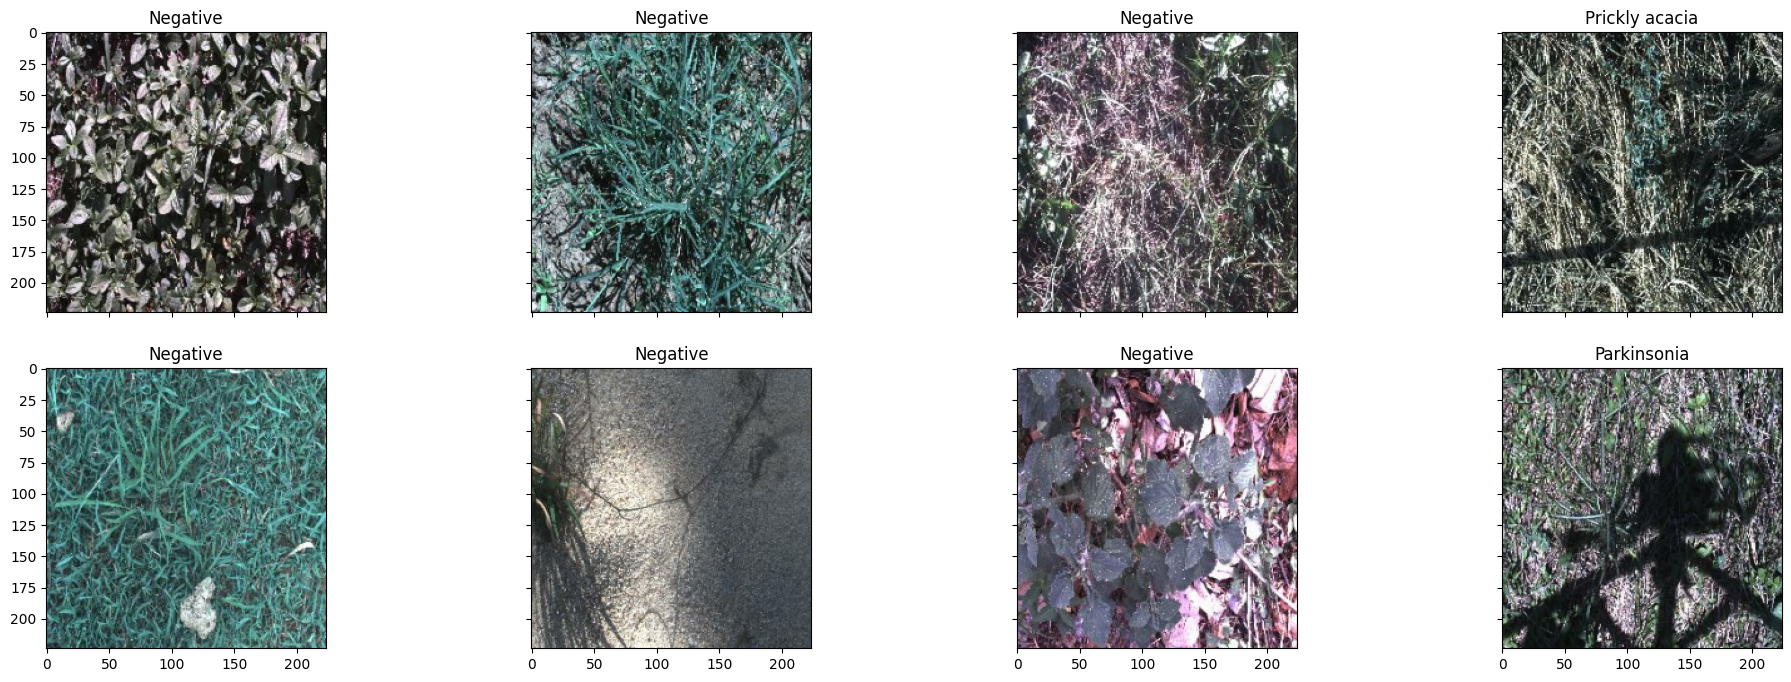

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    augs = [] if isTPU else [layers.RandomRotation(0.5, seed=seed, name='RR_Rot'), 
                            layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
                            layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),] ## can't run with TPU
    
    aug_model = keras.Sequential([
        layers.Input(IMG_SIZE),
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        *augs,
        layers.GaussianNoise(0.01, seed=SEED, name='RR_GNoise'),
        # layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')
    aug_model.summary()
    
    return aug_model


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('conv' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    FCLayer = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-FCLayer")
    
    return base_model , FCLayer

def buildModel(IMG_SIZE, fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, FCLayer = MobilenetV3Base(IMG_SIZE)
    base_model.trainable = True
    FCLayer.trainable = True
    FCLayer.summary()
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.3, seed=SEED)(x) 
    
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = FCLayer(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
with strategy.scope():
    model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Model: "MobileNet-FCLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 576)]       0         
                                                                 
 Conv_2 (Conv2D)             (None, 1, 1, 1024)        590848    
                                                                 
Total params: 590848 (2.25 MB)
Trainable params: 590848 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Base Model: MobilenetV3small_base_
228
Model: "augment_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RR_Bright (RandomBrightnes  (None, 224, 224, 3)       0         
 s)                                                              
               

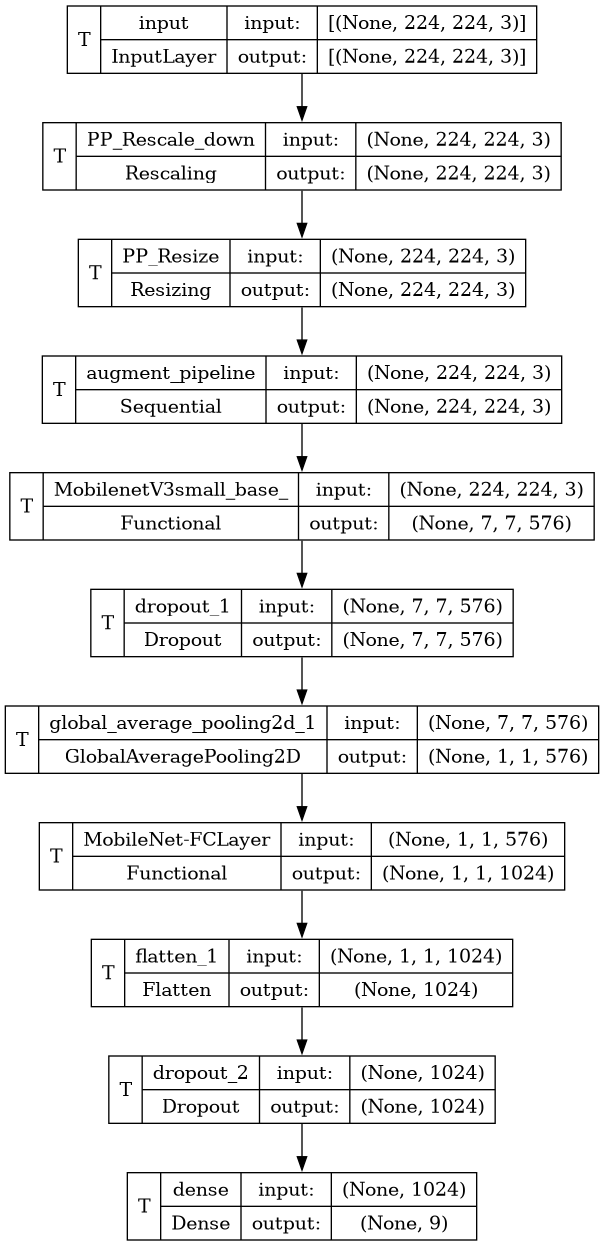

In [20]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import Adam, AdamW

checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor=ES_MONITOR)
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1, clipnorm=1.0) if not USE_ADAMW else AdamW(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

    def createWarmUpScheduler(epochs=5, inc_rate=0.5, init_lr=2e-6, final_lr=2e-5):
        def scheduler(e, lr):
            if e < epochs:
                new_lr =  lr + (lr * inc_rate)
                return new_lr if new_lr < final_lr else final_lr
            elif e == epochs:
                return final_lr
            else:
                return lr

        return scheduler
        
    warmup = keras.callbacks.LearningRateScheduler(createWarmUpScheduler(WARMUP_EPOCHS, WARMUP_INCREMENT_RATE, WARMUP_INIT_LR, INIT_LR1))

    callbacks = [checkpoint, early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])
    print(len(callbacks))

print(model.optimizer.get_config())

3
{'name': 'AdamW', 'weight_decay': 0.05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0002, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-28 07:43:19.919341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751096605.302842      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 55s 80ms/step - loss: 0.2534 - accuracy: 0.5337 - val_loss: 0.1146 - val_accuracy: 0.7010 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 23s 70ms/step - loss: 0.1457 - accuracy: 0.6617 - val_loss: 0.0821 - val_accuracy: 0.7784 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 23s 70ms/step - loss: 0.1147 - accuracy: 0.7066 - val_loss: 0.0714 - val_accuracy: 0.8047 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0977 - accuracy: 0.7432 - val_loss: 0.0607 - val_accuracy: 0.8341 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 23s 70ms/step - loss: 0.0871 - accuracy: 0.7634 - val_loss: 0.0552 - val_accuracy: 0.8492 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0784 - accuracy: 0.7850 - val_loss: 0.0503 - val_accuracy: 0.8575 - lr: 2.0000e-04
Epoch 7/300
329/329 [===================

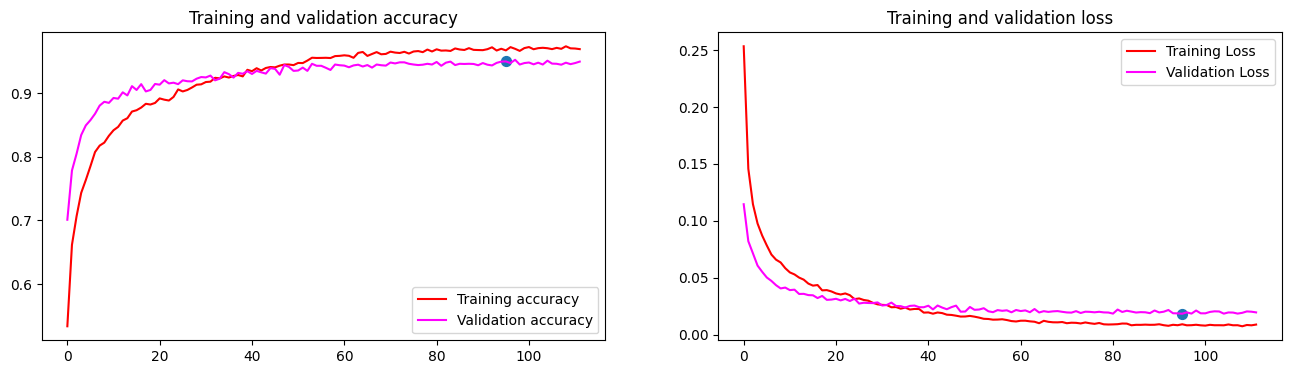

CPU times: user 1h 26min 7s, sys: 6min 23s, total: 1h 32min 30s
Wall time: 43min 26s


In [22]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 24ms/step - loss: 0.0021 - accuracy: 0.9921
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99107   0.98521   0.98813       676
       Lantana    0.99369   0.98901   0.99135       637
   Parkinsonia    0.98718   0.99515   0.99115       619
    Parthenium    0.98862   0.99184   0.99023       613
Prickly acacia    0.99210   0.98587   0.98898       637
   Rubber vine    0.98682   0.99008   0.98845       605
     Siam weed    0.99381   0.99689   0.99535       644
    Snake weed    0.98055   0.99180   0.98615       610
      Negative    0.99487   0.99359   0.99423      5463

      accuracy                        0.99219     10504
     macro avg    0.98986   0.99105   0.99044     10504
  weighted avg    0.99221   0.99219   0.99220     10504


                False Positive Rate  Accuracy
Chinee apple               0.000611  0.985207
Lantana                    0.000405  0.989011
Parkinsonia                0.000809  0.995153
Parthenium                 0.000708  0.991843
Prickly acacia    

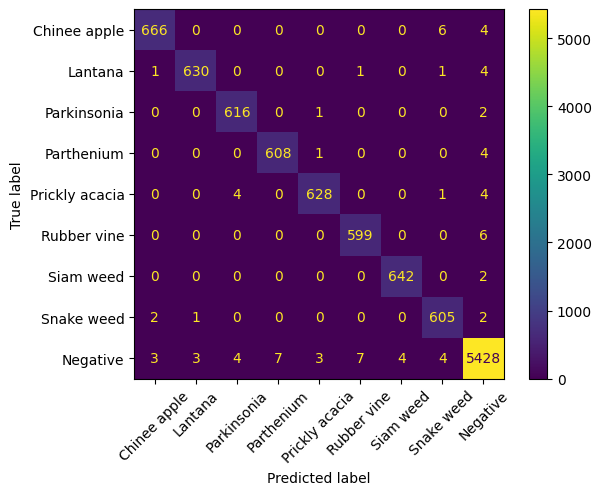


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0211 - accuracy: 0.9449
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.88942   0.82222   0.85450       225
       Lantana    0.93564   0.88732   0.91084       213
   Parkinsonia    0.97059   0.96117   0.96585       206
    Parthenium    0.97980   0.95098   0.96517       204
Prickly acacia    0.91818   0.95283   0.93519       212
   Rubber vine    0.93627   0.94554   0.94089       202
     Siam weed    0.93488   0.93488   0.93488       215
    Snake weed    0.85366   0.86207   0.85784       203
      Negative    0.95720   0.96981   0.96347      1822

      accuracy                        0.94289      3502
     macro avg    0.93063   0.92076   0.92540      3502
  weighted avg    0.94270   0.94289   0.94261      3502


                False Positive Rate  Accuracy
Chinee apple               0.007019  0.822222
Lantana                    0.003953  0.887324
Parkinsonia                0.001820  0.961165
Parthenium                 0.001213  0.950980
Prickly acacia    

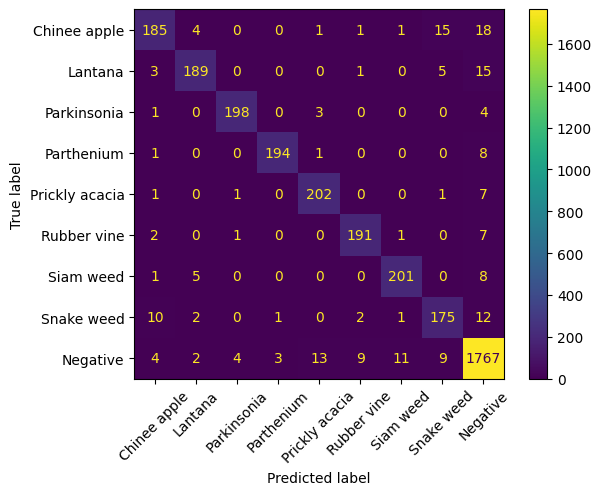


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 0.4928 - accuracy: 0.5238
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.19828   0.10222   0.13490       225
       Lantana    0.35714   0.09390   0.14870       213
   Parkinsonia    0.61538   0.07767   0.13793       206
    Parthenium    0.29825   0.08293   0.12977       205
Prickly acacia    0.30000   0.05634   0.09486       213
   Rubber vine    0.54286   0.09406   0.16034       202
     Siam weed    0.54054   0.09302   0.15873       215
    Snake weed    0.25843   0.11330   0.15753       203
      Negative    0.55300   0.92532   0.69228      1821

      accuracy                        0.52384      3503
     macro avg    0.40710   0.18208   0.20167      3503
  weighted avg    0.47326   0.52384   0.42717      3503


                False Positive Rate  Accuracy
Chinee apple               0.028371  0.102222
Lantana                    0.010942  0.093897
Parkinsonia                0.003033  0.077670
Parthenium                 0.012129  0.082927
Prickly acacia    

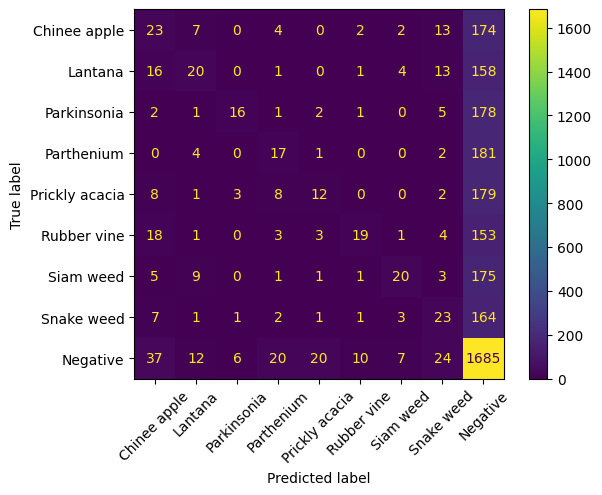

In [23]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Freezing Base Model

In [24]:
with strategy.scope():
    for layer in model.layers:
        if 'base' in layer.name.lower():
            print("Freezing layer", layer.name, layer.trainable)
            layer.trainable = False

Freezing layer MobilenetV3small_base_ True


# Evaluations #1.1b

Test After Freezing
Validation Set Stats
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0193 - accuracy: 0.9432
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.88732   0.84000   0.86301       225
       Lantana    0.95567   0.91080   0.93269       213
   Parkinsonia    0.98522   0.97087   0.97800       206
    Parthenium    0.95215   0.97549   0.96368       204
Prickly acacia    0.93088   0.95283   0.94172       212
   Rubber vine    0.96465   0.94554   0.95500       202
     Siam weed    0.96190   0.93953   0.95059       215
    Snake weed    0.84211   0.86700   0.85437       203
      Negative    0.96848   0.97805   0.97324      1822

      accuracy                        0.95231      3502
     macro avg    0.93871   0.93112   0.93470      3502
  weighted avg    0.95229   0.95231   0.95217      3502


                False Positive Rate  Accuracy
Chinee apple               0.007324  0.840000
Lantana                    0.002736  0.910798
Parkinsonia                0.000910  0.970874
Parthenium                 0.003032  0.975490
Prickly acacia    

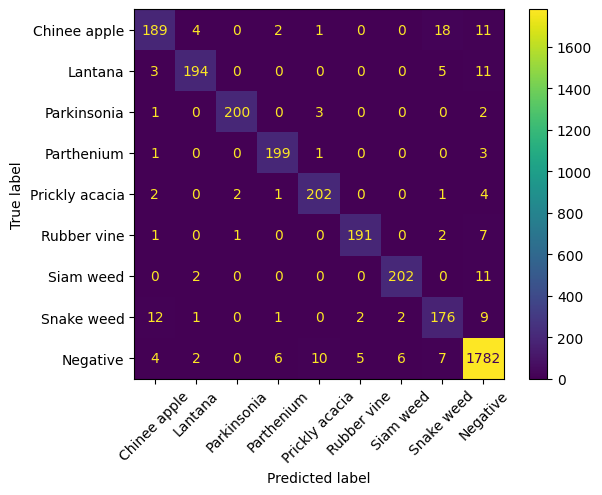

Test Set Stats
model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 0.4928 - accuracy: 0.5238
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91038   0.85778   0.88330       225
       Lantana    0.95122   0.91549   0.93301       213
   Parkinsonia    0.95631   0.95631   0.95631       206
    Parthenium    0.93365   0.96098   0.94712       205
Prickly acacia    0.92019   0.92019   0.92019       213
   Rubber vine    0.98964   0.94554   0.96709       202
     Siam weed    0.98529   0.93488   0.95943       215
    Snake weed    0.89055   0.88177   0.88614       203
      Negative    0.96125   0.98078   0.97092      1821

      accuracy                        0.95204      3503
     macro avg    0.94427   0.92819   0.93594      3503
  weighted avg    0.95198   0.95204   0.95181      3503


                False Positive Rate  Accuracy
Chinee apple               0.005796  0.857778
Lantana                    0.003040  0.915493
Parkinsonia                0.002730  0.956311
Parthenium                 0.004245  0.960976
Prickly acacia    

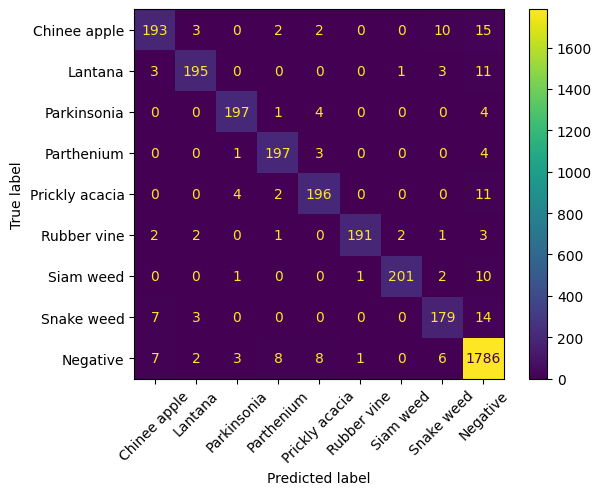

In [25]:
## Test After Freezing
print("Test After Freezing")
print("Validation Set Stats")        
a, b = eval_model(model, validation_generator)

print("Test Set Stats")   
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83682   0.88889   0.86207       225
       Lantana    0.89686   0.93897   0.91743       213
   Parkinsonia    0.95631   0.95631   0.95631       206
    Parthenium    0.93365   0.96098   0.94712       205
Prickly acacia    0.85062   0.96244   0.90308       213
   Rubber vine    0.98964   0.94554   0.96709       202
     Siam weed    0.98529   0.93488   0.95943       215
    Snake weed    0.89055   0.88177   0.88614       203
      Negative    0.97255   0.95332   0.96284      1821

      accuracy                        0.94376      3503
     macro avg    0.92359   0.93590   0.92906      3503
  weighted avg    0.94560   0.94376   0.94426      3503


                False Positive Rate  Accuracy
Chinee apple               0.011897  0.888889
Lantana                    0.006991  0.938967
Parkinsonia                0.002730  0.956311
Parthenium                 0.004245  0.960976
Prickly acacia    

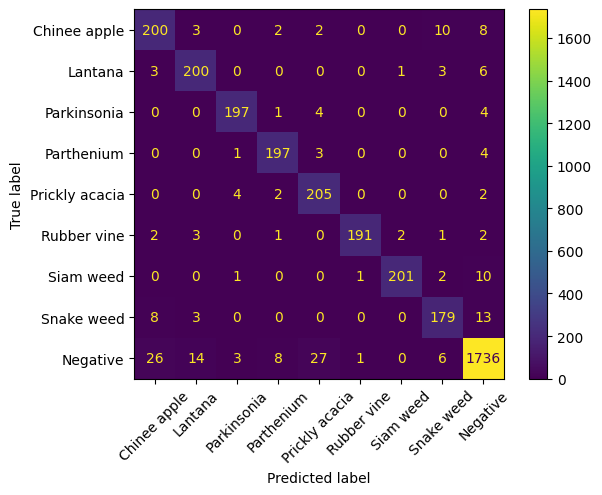

In [26]:
printStats(a,b,0.11)

# Trial 2

In [27]:
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=INIT_LR2,  weight_decay=W_DECAY2, clipnorm=2.0) if not USE_ADAMW else AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=ES_MONITOR, factor=LR_REDUCTION_FACTOR, patience=ES_PATIENCE, verbose=1, min_lr=MIN_LR2)


print(model.optimizer.get_config())

{'name': 'AdamW', 'weight_decay': 0.0005, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 2e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-28 08:31:21.004476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 18s 40ms/step - loss: 0.0198 - accuracy: 0.9299 - val_loss: 0.0172 - val_accuracy: 0.9512 - lr: 2.0000e-06
Epoch 2/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0185 - accuracy: 0.9402 - val_loss: 0.0173 - val_accuracy: 0.9526 - lr: 2.0000e-06
Epoch 3/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0185 - accuracy: 0.9393 - val_loss: 0.0174 - val_accuracy: 0.9523 - lr: 2.0000e-06
Epoch 4/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0191 - accuracy: 0.9382 - val_loss: 0.0175 - val_accuracy: 0.9523 - lr: 2.0000e-06
Epoch 5/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0181 - accuracy: 0.9403 - val_loss: 0.0176 - val_accuracy: 0.9529 - lr: 2.0000e-06
Epoch 6/300
329/329 [==============================] - 12s 36ms/step - loss: 0.0178 - accuracy: 0.9409 - val_loss: 0.0177 - val_accuracy: 0.9515 - lr: 2.0000e-06
Epoch 7/300
329/329 [===================

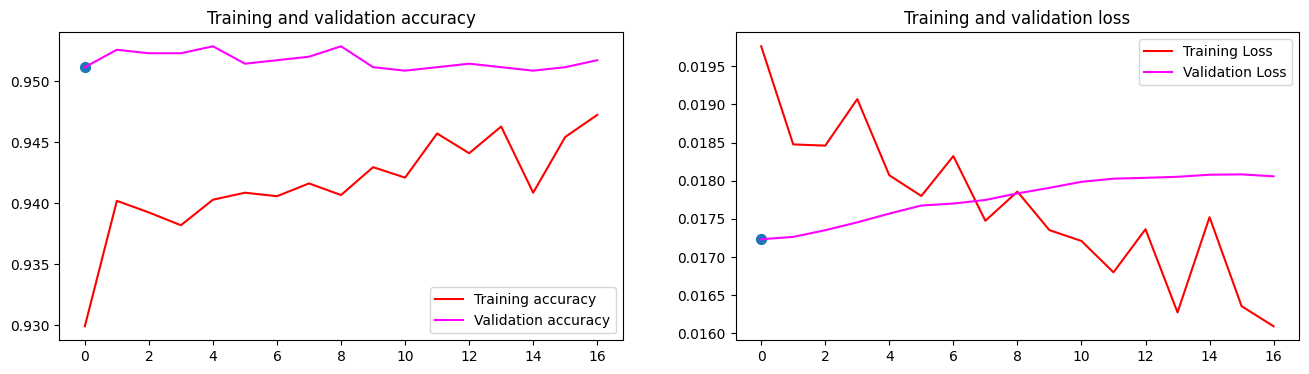

In [28]:
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Checkpoint")
model.save("2-"+MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)


# Accuracy / Loss Plots

Total Epochs: range(0, 129)


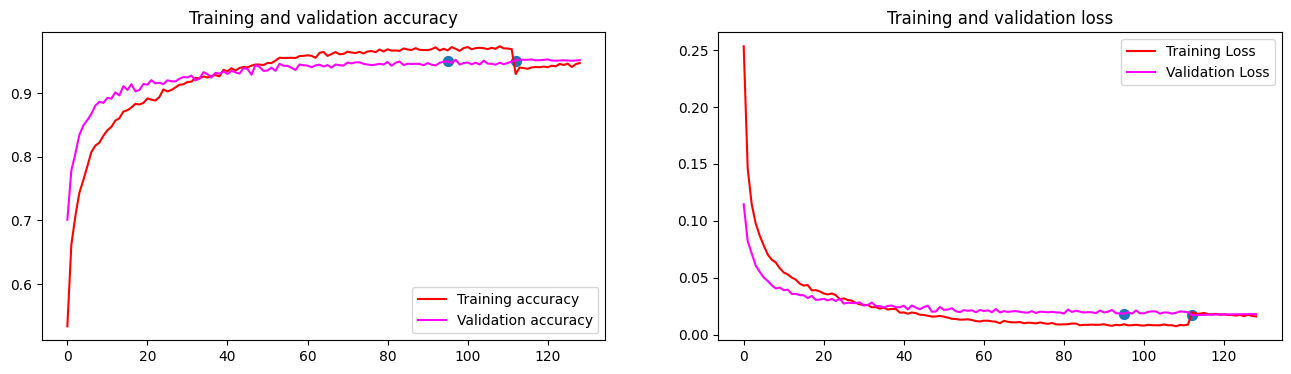

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 112)


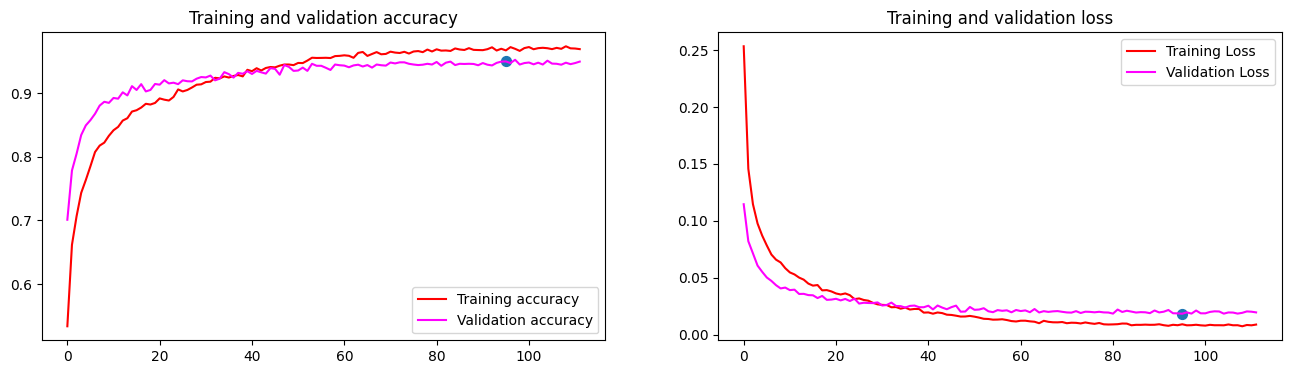

Total Epochs: range(0, 17)


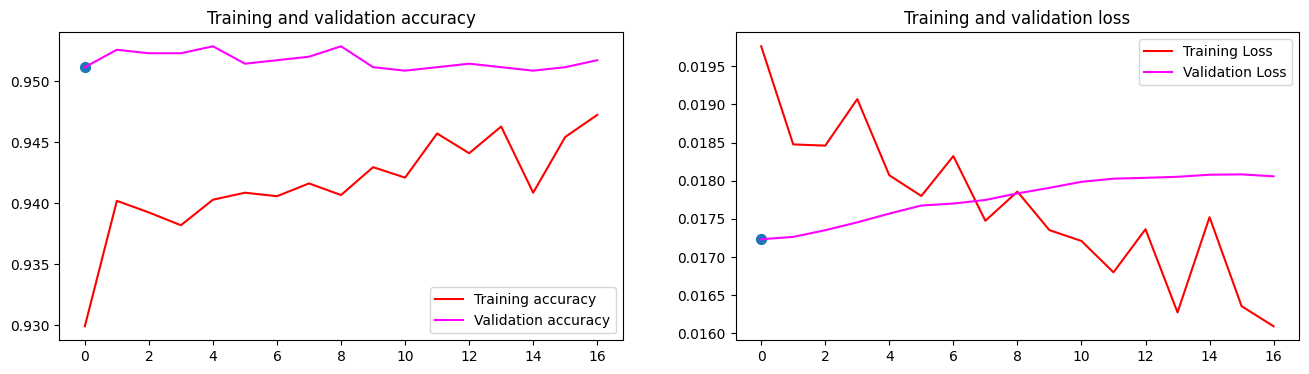

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 7s 21ms/step - loss: 0.0012 - accuracy: 0.9951
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99407   0.99260   0.99334       676
       Lantana    1.00000   0.99372   0.99685       637
   Parkinsonia    0.99354   0.99354   0.99354       619
    Parthenium    0.98551   0.99837   0.99190       613
Prickly acacia    0.98744   0.98744   0.98744       637
   Rubber vine    0.99670   0.99835   0.99752       605
     Siam weed    0.99535   0.99689   0.99612       644
    Snake weed    0.99184   0.99672   0.99428       610
      Negative    0.99707   0.99561   0.99634      5463

      accuracy                        0.99514     10504
     macro avg    0.99350   0.99480   0.99415     10504
  weighted avg    0.99516   0.99514   0.99515     10504


                False Positive Rate  Accuracy
Chinee apple               0.000407  0.992604
Lantana                    0.000000  0.993721
Parkinsonia                0.000405  0.993538
Parthenium                 0.000910  0.998369
Prickly acacia    

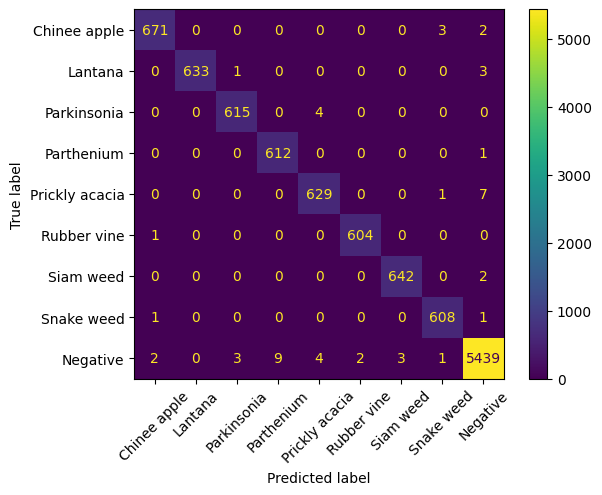


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 21ms/step - loss: 0.0172 - accuracy: 0.9512
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.89100   0.83556   0.86239       225
       Lantana    0.95545   0.90610   0.93012       213
   Parkinsonia    0.98039   0.97087   0.97561       206
    Parthenium    0.94737   0.97059   0.95884       204
Prickly acacia    0.92661   0.95283   0.93953       212
   Rubber vine    0.96465   0.94554   0.95500       202
     Siam weed    0.95775   0.94884   0.95327       215
    Snake weed    0.83886   0.87192   0.85507       203
      Negative    0.96841   0.97585   0.97212      1822

      accuracy                        0.95117      3502
     macro avg    0.93672   0.93090   0.93355      3502
  weighted avg    0.95121   0.95117   0.95104      3502


                False Positive Rate  Accuracy
Chinee apple               0.007019  0.835556
Lantana                    0.002736  0.906103
Parkinsonia                0.001214  0.970874
Parthenium                 0.003335  0.970588
Prickly acacia    

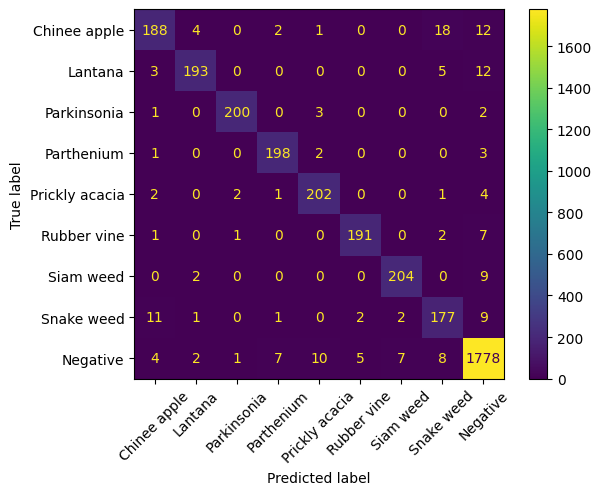


Testn Set Statistics
model.evaluate
110/110 [==============================] - 2s 21ms/step - loss: 0.0187 - accuracy: 0.9529
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91038   0.85778   0.88330       225
       Lantana    0.95122   0.91549   0.93301       213
   Parkinsonia    0.95631   0.95631   0.95631       206
    Parthenium    0.93365   0.96098   0.94712       205
Prickly acacia    0.92056   0.92488   0.92272       213
   Rubber vine    0.98964   0.94554   0.96709       202
     Siam weed    0.98551   0.94884   0.96682       215
    Snake weed    0.88235   0.88670   0.88452       203
      Negative    0.96380   0.97968   0.97168      1821

      accuracy                        0.95290      3503
     macro avg    0.94371   0.93069   0.93695      3503
  weighted avg    0.95287   0.95290   0.95272      3503


                False Positive Rate  Accuracy
Chinee apple               0.005796  0.857778
Lantana                    0.003040  0.915493
Parkinsonia                0.002730  0.956311
Parthenium                 0.004245  0.960976
Prickly acacia    

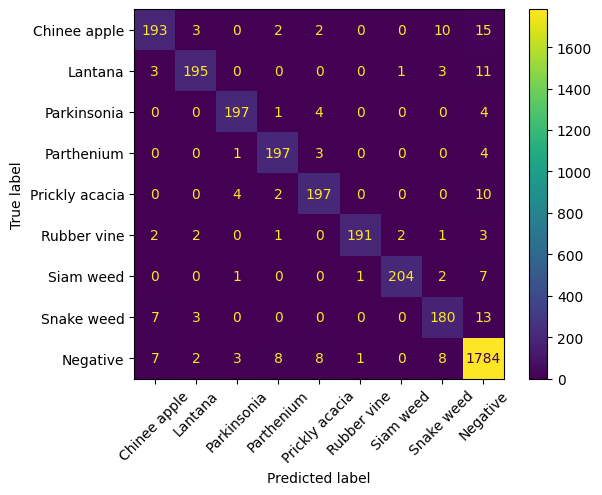

In [31]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83682   0.88889   0.86207       225
       Lantana    0.89286   0.93897   0.91533       213
   Parkinsonia    0.95631   0.95631   0.95631       206
    Parthenium    0.93365   0.96098   0.94712       205
Prickly acacia    0.84362   0.96244   0.89912       213
   Rubber vine    0.99479   0.94554   0.96954       202
     Siam weed    0.98558   0.95349   0.96927       215
    Snake weed    0.88235   0.88670   0.88452       203
      Negative    0.97466   0.95058   0.96247      1821

      accuracy                        0.94376      3503
     macro avg    0.92229   0.93821   0.92953      3503
  weighted avg    0.94587   0.94376   0.94435      3503


                False Positive Rate  Accuracy
Chinee apple               0.011897  0.888889
Lantana                    0.007295  0.938967
Parkinsonia                0.002730  0.956311
Parthenium                 0.004245  0.960976
Prickly acacia    

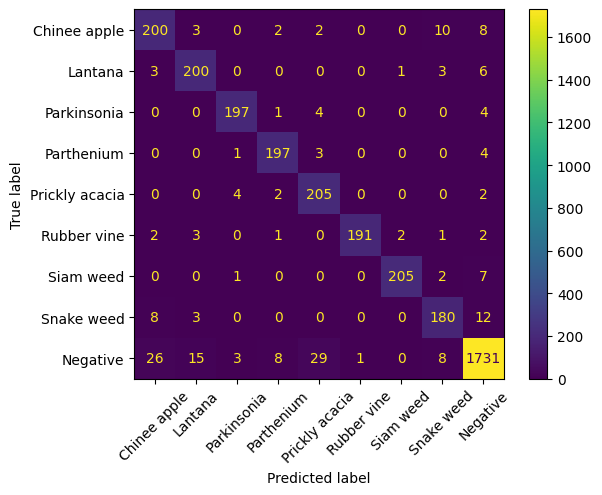

In [32]:
printStats(a,b,0.11)

## Clear Files

In [33]:
shutil.rmtree(base_dir)